In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from astropy.time import Time, TimeDelta
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord

from lsst_efd_client import EfdClient
from lsst.sitcom.vandv.efd import create_efd_client

In [2]:
def read_rubintv(fname, today):
    df = pd.read_json(fname).T
    times = df[['UTC','UTC wide']]

    df = df.drop(columns=['UTC','UTC wide'])
    if 'UTC fast' in df.columns:
        df = df.drop(columns=['UTC fast',])
    df = df.astype(float)
    
    # set time vectors and deal with nans in the UTC columns
    timenew = np.zeros(len(df), dtype='datetime64[ns]')
    nat = pd.isna(times['UTC'])
    timenew[nat] = np.datetime64("NAT")
    timenew[~nat] = (today+'T'+ times[~nat]['UTC'].to_numpy()).astype(np.datetime64)
    timenew2 = np.zeros(len(df), dtype='datetime64[ns]')
    nat = pd.isna(times['UTC wide'])
    timenew2[nat] = np.datetime64("NAT")
    timenew2[~nat] = (today+'T'+ times[~nat]['UTC wide'].to_numpy()).astype(np.datetime64)
    
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [8]:
client = create_efd_client()

In [3]:
diff_dict = {}

In [4]:
def forward_reverse(forward_grid, backward_grid):
    # Find groups of exposures by looking for big jumps in Az/El:
    
    # Forward:
    # (first deal with nans)
    test_alt = forward_grid['Alt'].copy()
    test_az = forward_grid['Az2'].copy()
    az_nans = pd.isna(test_az).to_numpy().nonzero()[0]
    alt_nans = pd.isna(test_alt).to_numpy().nonzero()[0]
    assert (az_nans == alt_nans).all()
    for n in az_nans:
        if (n + 1) == len(test_alt): continue
        test_alt.iloc[n] = test_alt.iloc[n+1]
        test_az.iloc[n] = test_az.iloc[n+1]
        
    #az_diffs = np.diff(forward_grid['Az'])
    az_diffs = np.diff(test_az)
    #el_diffs = np.diff(forward_grid['Alt'])
    el_diffs = np.diff(test_alt)
    group_seps = np.flatnonzero((abs(az_diffs) > 5) | (abs(el_diffs) > 5))
    forward_groups = np.zeros(len(forward_grid))
    sep_index0 = 0
    for i, s in enumerate(group_seps):
        sep_index1 = s + 1
        forward_groups[sep_index0:sep_index1] = i
        sep_index0 = sep_index1
    forward_groups[sep_index0:] = i + 1

    # Backward:
    test_alt = backward_grid['Alt'].copy()
    test_az = backward_grid['Az2'].copy()
    az_nans = pd.isna(test_az).to_numpy().nonzero()[0]
    alt_nans = pd.isna(test_alt).to_numpy().nonzero()[0]
    assert (az_nans == alt_nans).all()
    for n in az_nans:
        if (n + 1) == len(test_alt): continue
        test_alt.iloc[n] = test_alt.iloc[n+1]
        test_az.iloc[n] = test_az.iloc[n+1]
        
    #az_diffs = np.diff(backward_grid['Az'])
    az_diffs = np.diff(test_az)
    #el_diffs = np.diff(backward_grid['Alt'])
    el_diffs = np.diff(test_alt)
    group_seps = np.flatnonzero((abs(az_diffs) > 5) | (abs(el_diffs) > 5))
    backward_groups = np.zeros(len(backward_grid))
    sep_index0 = 0
    for i, s in enumerate(group_seps):
        sep_index1 = s + 1
        backward_groups[sep_index0:sep_index1] = i
        sep_index0 = sep_index1
    backward_groups[sep_index0:] = i + 1
    
    # Get the mean and individual measurements for each group:
    forward_azs = []
    forward_els = []
    forward_dazs = []
    forward_dels = []
    forward_all_dazs = []
    forward_all_dels = []
    for group in np.unique(forward_groups):
        group_images = forward_grid.loc[forward_groups == group]
        avg_az = np.nanmean(group_images['Az2'])
        avg_el = np.nanmean(group_images['Alt'])
        #print(group_images[['Calculated Az', 'Calculated Alt']])
        print('Forward Avg:', group, len(group_images), avg_az, avg_el)
        print(' indices:', group_images.index[0], '-', group_images.index[-1])
        if np.isnan(avg_az): continue
        forward_azs.append(avg_az)
        forward_els.append(avg_el)
        avg_daz = np.nanmean(group_images['Delta Az Arcsec'])
        avg_del = np.nanmean(group_images['Delta Alt Arcsec'])
        #print(group_images[['Calculated Az', 'Calculated Alt']])
        #print('Forward Delta Avg:', group, len(group_images), avg_daz, avg_del)
        forward_dazs.append(avg_daz)
        forward_dels.append(avg_del)
        forward_all_dazs.append(group_images['Delta Az Arcsec'])
        forward_all_dels.append(group_images['Delta Alt Arcsec'])
        
    backward_azs = []
    backward_els = []
    backward_dazs = []
    backward_dels = []
    backward_all_dazs = []
    backward_all_dels = []
    for group in np.unique(backward_groups):
        group_images = backward_grid.loc[backward_groups == group]
        avg_az = np.mean(group_images['Az2'])
        avg_el = np.mean(group_images['Alt'])
        #print(group_images[['Calculated Az', 'Calculated Alt']])
        print("Reverse Avg:", group, len(group_images), avg_az, avg_el)
        print(' indices:', group_images.index[0], '-', group_images.index[-1])
        if np.isnan(avg_az): continue
        backward_azs.append(avg_az)
        backward_els.append(avg_el)
        avg_daz = np.mean(group_images['Delta Az Arcsec'])
        avg_del = np.mean(group_images['Delta Alt Arcsec'])
        #print("Reverse Delta Avg:", group, len(group_images), avg_daz, avg_del)
        backward_dazs.append(avg_daz)
        backward_dels.append(avg_del)
        backward_all_dazs.append(group_images['Delta Az Arcsec'])
        backward_all_dels.append(group_images['Delta Alt Arcsec'])
        
    forward_azs = np.array(forward_azs)
    forward_dazs = np.array(forward_dazs)
    forward_els = np.array(forward_els)
    forward_dels = np.array(forward_dels)
    backward_azs = np.array(backward_azs)
    backward_dazs = np.array(backward_dazs)
    backward_els = np.array(backward_els)
    backward_dels = np.array(backward_dels)

    
    forward_cat = SkyCoord(forward_azs * u.degree, forward_els * u.degree)
    backward_cat = SkyCoord(backward_azs * u.degree, backward_els * u.degree)
    
    # Matching probably not the best way to go because groups not that clear, some have repeating positions
    # 180 and -180 are not disambiguated.
    id, d2d, d3d = forward_cat.match_to_catalog_sky(backward_cat)
    good_matches = d2d.degree < 1
    print(len(d2d), good_matches.sum())
    print(id)
    

    az_diff = forward_dazs[good_matches] - backward_dazs[id[good_matches]]
    el_diff = forward_dels[good_matches] - backward_dels[id[good_matches]]
    result_dict = {'forward_azs': forward_azs, 'forward_els': forward_els, 'forward_dazs': forward_dazs, 
                   'forward_dels': forward_dels, 'forward_all_dazs': forward_all_dazs, 
                   'forward_all_dels': forward_all_dels,'backward_azs': backward_azs, 'backward_els': backward_els,
                   'backward_dazs': backward_dazs, 'backward_dels': backward_dels,
                   'backward_all_dazs': backward_all_dazs, 'backward_all_dels': backward_all_dels,
                   'diff_azs': forward_azs[good_matches], 'diff_els': forward_els[good_matches],
                   'diff_dazs': az_diff, 'diff_dels': el_diff}
    return result_dict

# 03-22-2023

In [6]:
#startracker_data = getStartracker(date)
date = 22
file = f'/home/c/csaunder/stack_projects/TMA_tests/startracker/dayObs_202303{date}.json'
date_str = f'2023-03-{date + 1}'
startracker_data = read_rubintv(file, date_str)

### The night logs say that the forward grid is img number 18 - 328 and backward is 329 - 568

In [7]:
forward_ind = (startracker_data.index >= 18) & (startracker_data.index <= 328)
forward_grid = startracker_data.loc[forward_ind]

backward_ind = (startracker_data.index >= 329) & (startracker_data.index <= 568)
backward_grid = startracker_data.loc[backward_ind]


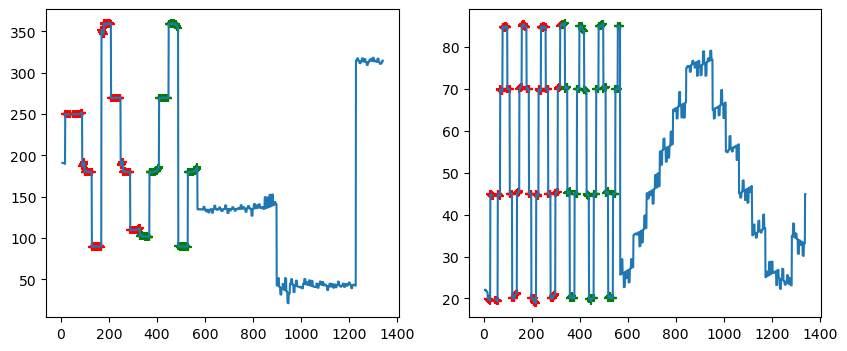

In [263]:
fig, subs = plt.subplots(1,2, sharex=True, figsize=(10, 4))
subs[0].plot(startracker_data.index, startracker_data['Calculated Az'])
subs[0].scatter(forward_grid.index, forward_grid['Calculated Az'], marker='+', color='r')
subs[0].scatter(backward_grid.index, backward_grid['Calculated Az'], marker='+', color='g')
subs[1].plot(startracker_data.index, startracker_data['Calculated Alt'])
subs[1].scatter(forward_grid.index, forward_grid['Calculated Alt'], marker='+', color='r')
subs[1].scatter(backward_grid.index, backward_grid['Calculated Alt'], marker='+', color='g')

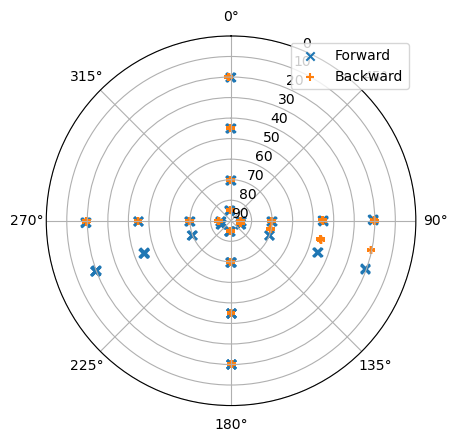

In [15]:
# Polar version
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#pts = ax.scatter((startracker_data['Calculated Az'].to_numpy() * u.degree).to(u.radian),
#                 startracker_data['Calculated Alt'].to_numpy())#, c=groups)
pts = ax.scatter((forward_grid['Calculated Az'].to_numpy() * u.degree).to(u.radian),
                 forward_grid['Calculated Alt'].to_numpy(), marker='x', label='Forward')
pts = ax.scatter((backward_grid['Calculated Az'].to_numpy() * u.degree).to(u.radian),
                 backward_grid['Calculated Alt'].to_numpy(), marker='+', label='Backward')

ax.set_rlim(90, 0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.legend()

In [13]:
dict_22 = forward_reverse(forward_grid, backward_grid)

Forward Avg: 0.0 10 249.84543476716104 19.677567702565426
 indices: 18 - 27
Forward Avg: 1.0 10 249.9262522974963 44.69980487595218
 indices: 28 - 37
Forward Avg: 2.0 10 249.7376653103609 19.457930590085795
 indices: 38 - 47
Forward Avg: 3.0 1 249.98098943350476 44.91170227419645
 indices: 48 - 48
Forward Avg: 4.0 10 249.76274439895533 19.509056434325363
 indices: 49 - 58
Forward Avg: 5.0 10 249.92618399560462 44.69992799011197
 indices: 59 - 68
Forward Avg: 6.0 10 250.11590206206648 69.69822961932607
 indices: 69 - 78
Forward Avg: 7.0 10 250.97561660685818 84.70651334865504
 indices: 79 - 88
Forward Avg: 8.0 10 189.1528717232182 84.93108484592317
 indices: 89 - 98
Forward Avg: 9.0 10 180.67465421214865 69.99906632584766
 indices: 99 - 108
Forward Avg: 10.0 10 180.13703363012297 45.00037896170019
 indices: 109 - 118
Forward Avg: 11.0 10 179.93403562685776 20.000076770078195
 indices: 119 - 128
Forward Avg: 12.0 10 89.44722504966528 20.93990499421115
 indices: 129 - 138
Forward Avg: 13.

/tmp/ipykernel_25964/2151018916.py:70: RuntimeWarning: Mean of empty slice
  avg_daz = np.nanmean(group_images['Delta Az Arcsec'])
/tmp/ipykernel_25964/2151018916.py:71: RuntimeWarning: Mean of empty slice
  avg_del = np.nanmean(group_images['Delta Alt Arcsec'])


In [16]:
dict_22.keys()

dict_keys(['forward_azs', 'forward_els', 'forward_dazs', 'forward_dels', 'backward_azs', 'backward_els', 'diff_azs', 'diff_els', 'diff_dazs', 'diff_dels'])

In [44]:
# find plot limits
for k in ['forward_dazs', 'forward_dels', 'backward_dazs', 'backward_dels', 'diff_dazs', 'diff_dels']:
    diffs = dict_22[k]
    print(k, min(diffs), max(diffs), np.percentile(diffs, [5, 95]))

forward_dazs -25.78048316372226 120.46402877919688 [-10.68647793 101.07300534]
forward_dels -9.194121416725 120.01486280815095 [ -8.33666863 118.73314406]
backward_dazs -10.137106819579973 119.40993593625751 [ -9.71817044 105.08703551]
backward_dels -11.226985893276872 129.1250475389922 [ -5.82277725 124.54358472]
diff_dazs -41.770924433736454 26.72668981844302 [-33.1382867    6.94759842]
diff_dels -16.930809155229454 3.774310165426719 [-10.08824074   3.13579008]


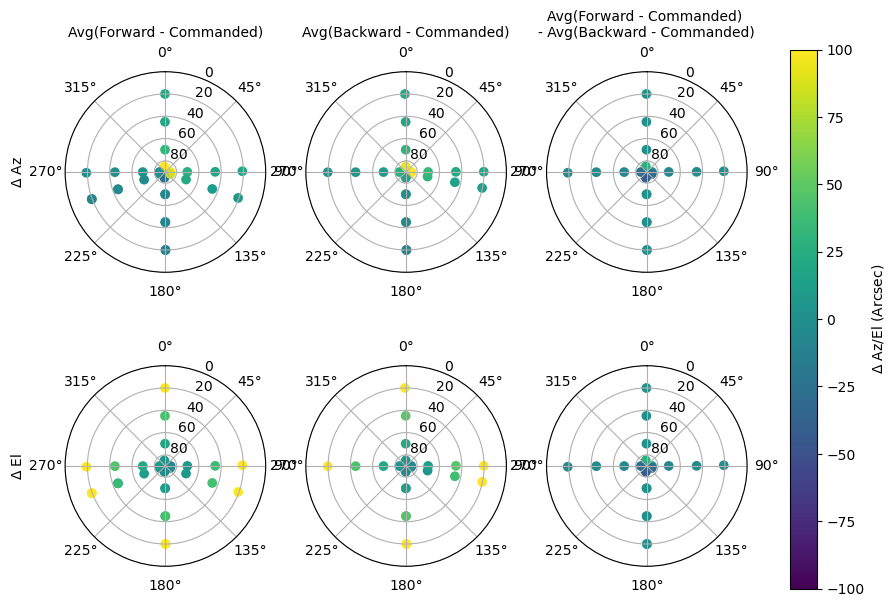

In [291]:
fig, ax = plt.subplots(2, 3, figsize=(11, 7), subplot_kw={'projection': 'polar'})
#ax = plt.sub
pts1 = ax[0, 0].scatter((dict_22['forward_azs'] * u.degree).to(u.radian), dict_22['forward_els'], c = dict_22['forward_dazs'],
                       vmin=-100, vmax=100)
ax[0, 1].scatter((dict_22['backward_azs'] * u.degree).to(u.radian), dict_22['backward_els'], c = dict_22['backward_dazs'],
                vmin=-100, vmax=100)
ax[0, 2].scatter((dict_22['diff_azs'] * u.degree).to(u.radian), dict_22['diff_els'], c = dict_22['diff_dazs'],
                 vmin=-100, vmax=100)
pts2 = ax[1, 0].scatter((dict_22['forward_azs'] * u.degree).to(u.radian), dict_22['forward_els'], c = dict_22['forward_dels'],
                        vmin=-100, vmax=100)
ax[1, 1].scatter((dict_22['backward_azs'] * u.degree).to(u.radian), dict_22['backward_els'], c = dict_22['backward_dels'],
                 vmin=-100, vmax=100)
ax[1, 2].scatter((dict_22['diff_azs'] * u.degree).to(u.radian), dict_22['diff_els'], c = dict_22['diff_dazs'],
                 vmin=-100, vmax=100)
#cbAx1 = fig.add_axes([0.92, 0.51, 0.03, 0.4])
#cbAx2 = fig.add_axes([0.92, 0.11, 0.03, 0.4])
fig.colorbar(pts1, label='$\Delta$ Az/El (Arcsec)', ax=ax)
#cb1 = fig.colorbar(pts1, label='$\Delta$ Az (degrees)', cax=cbAx1)
#cb2 = fig.colorbar(pts2, label='$\Delta$ Az (degrees)', cax=cbAx2)
ax[0, 0].set_ylabel('$\Delta$ Az')
ax[0, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[1, 0].set_ylabel('$\Delta$ El')
ax[1, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[0, 0].set_title('Avg(Forward - Commanded)', fontsize=10)
ax[0, 1].set_title('Avg(Backward - Commanded)', fontsize=10)
ax[0, 2].set_title('Avg(Forward - Commanded) \n- Avg(Backward - Commanded)', fontsize=10)
ax[0, 0].set_theta_zero_location("N")
ax[0, 0].set_theta_direction(-1)
ax[0, 0].set_rlim(90, 0)
ax[1, 0].set_theta_zero_location("N")
ax[1, 0].set_theta_direction(-1)
ax[1, 0].set_rlim(90, 0)
ax[0, 1].set_theta_zero_location("N")
ax[0, 1].set_theta_direction(-1)
ax[0, 1].set_rlim(90, 0)
ax[1, 1].set_theta_zero_location("N")
ax[1, 1].set_theta_direction(-1)
ax[1, 1].set_rlim(90, 0)
ax[0, 2].set_theta_zero_location("N")
ax[0, 2].set_theta_direction(-1)
ax[0, 2].set_rlim(90, 0)
ax[1, 2].set_theta_zero_location("N")
ax[1, 2].set_theta_direction(-1)
ax[1, 2].set_rlim(90, 0)
plt.savefig('ForwardReverse_03_22.png')

# 03-21-2023

In [125]:
date = 21
file = f'/home/c/csaunder/stack_projects/TMA_tests/startracker/dayObs_202303{date}.json'
date_str = f'2023-03-{date + 1}'
startracker_data = read_rubintv(file, date_str)
startracker_data = startracker_data.loc[11:]

In [130]:
startracker_data[['UTC', 'Az', 'Alt']][:100]

,UTC,Az,Alt
11,2023-03-22 00:33:56,109.487113,21.055294
12,2023-03-22 00:34:10,109.463856,21.103358
13,2023-03-22 00:34:25,109.440609,21.151605
14,2023-03-22 00:34:39,109.417616,21.199428
15,2023-03-22 00:34:53,109.394635,21.247172
...,...,...,...
106,2023-03-22 01:00:24,195.302661,84.807191
107,2023-03-22 01:00:38,195.804557,84.793711
108,2023-03-22 01:00:52,196.313577,84.779583
109,2023-03-22 01:01:06,196.813492,84.765151


In [225]:
forward_ind = (startracker_data.index >= 11) & (startracker_data.index <= 570)
forward_grid = startracker_data.loc[forward_ind]

backward_ind = (startracker_data.index >= 728) & (startracker_data.index <= 1305)
backward_grid = startracker_data.loc[backward_ind]

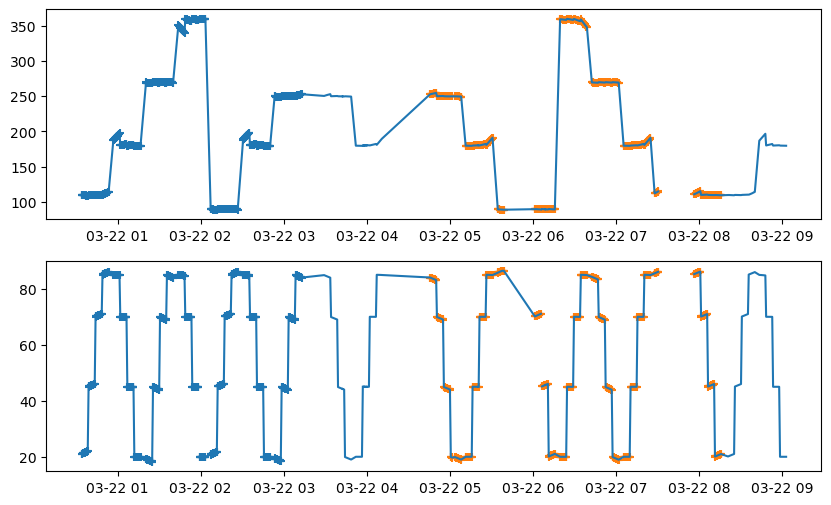

In [134]:
fig, subs = plt.subplots(2, figsize=(10, 6))
subs[0].plot(startracker_data['UTC'], startracker_data['Az'])
subs[0].scatter(forward_grid['UTC'], forward_grid['Az'], marker='+')
subs[0].scatter(backward_grid['UTC'], backward_grid['Az'], marker='+')
subs[1].plot(startracker_data['UTC'], startracker_data['Alt'])
subs[1].scatter(forward_grid['UTC'], forward_grid['Alt'], marker='+')
subs[1].scatter(backward_grid['UTC'], backward_grid['Alt'], marker='+')

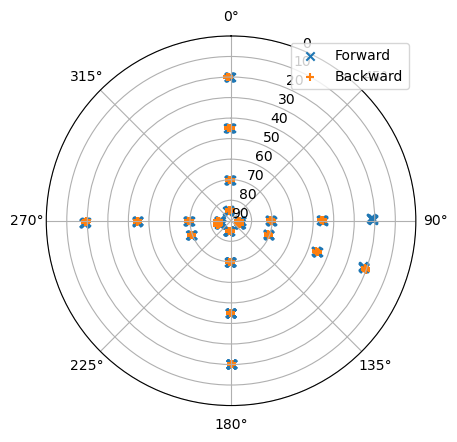

In [145]:
# Polar version
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
#pts = ax.scatter((startracker_data['Calculated Az'].to_numpy() * u.degree).to(u.radian),
#                 startracker_data['Calculated Alt'].to_numpy())#, c=groups)
pts = ax.scatter((forward_grid['Calculated Az'].to_numpy() * u.degree).to(u.radian),
                 forward_grid['Calculated Alt'].to_numpy(), marker='x', label='Forward')
pts = ax.scatter((backward_grid['Calculated Az'].to_numpy() * u.degree).to(u.radian),
                 backward_grid['Calculated Alt'].to_numpy(), marker='+', label='Backward')

ax.set_rlim(90, 0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.legend()

In [233]:
az2 = forward_grid['Az'].copy()
az2.loc[:330] -= 360
print(len(forward_grid.columns))
forward_grid['Az2']
#forward_grid.insert(len(forward_grid.columns), 'Az2', az2)

61


11    -250.512887
12    -250.536144
13    -250.559391
14    -250.582384
15    -250.605365
          ...    
569    252.770193
570    252.882877
414           NaN
439           NaN
499           NaN
Name: Az2, Length: 560, dtype: float64

In [234]:
az2 = backward_grid['Az'].copy()
az2.loc[973:] -= 360
print(len(backward_grid.columns))
#_grid['Az2']
backward_grid.insert(len(backward_grid.columns), 'Az2', az2)

60


In [252]:
dict_21 = forward_reverse(forward_grid, backward_grid, forward_subtract=330, backward_subtract=973)

Forward Avg: 0.0 20 -250.73096222618346 21.508944850838017
 indices: 11 - 30
Forward Avg: 1.0 20 -250.1391177069945 45.54402177543964
 indices: 31 - 50
Forward Avg: 2.0 20 -249.78231294754377 70.54748714449845
 indices: 51 - 70
Forward Avg: 3.0 20 -247.79059700066006 85.53298741181301
 indices: 71 - 90
Forward Avg: 4.0 20 -167.56877920160096 84.8665981271387
 indices: 91 - 110
Forward Avg: 5.0 20 -178.7510867050798 69.99441667457018
 indices: 111 - 130
Forward Avg: 6.0 20 -179.75373593561343 45.00070424945941
 indices: 131 - 150
Forward Avg: 7.0 20 -180.12410465090468 20.002092358902264
 indices: 151 - 170
Forward Avg: 8.0 20 -90.7537243520439 18.698128829856444
 indices: 171 - 190
Forward Avg: 9.0 20 -90.33447163135345 44.41747285943946
 indices: 191 - 210
Forward Avg: 10.0 20 -90.33221180934399 69.41053583241815
 indices: 211 - 230
Forward Avg: 11.0 20 -90.29681338336458 84.42596793887444
 indices: 231 - 250
Forward Avg: 12.0 20 -14.74028816574572 84.82757674414623
 indices: 251 - 27

/tmp/ipykernel_1893/555177592.py:72: RuntimeWarning: Mean of empty slice
  avg_daz = np.nanmean(group_images['Delta Az Arcsec'])
/tmp/ipykernel_1893/555177592.py:73: RuntimeWarning: Mean of empty slice
  avg_del = np.nanmean(group_images['Delta Alt Arcsec'])


In [156]:
# find plot limits
for k in ['forward_dazs', 'forward_dels', 'backward_dazs', 'backward_dels', 'diff_dazs', 'diff_dels']:
    diffs = dict_21[k]
    print(k, min(diffs), max(diffs), np.percentile(diffs, [5, 95]))

forward_dazs -150.08335961884245 23.979402351803405 [nan nan]
forward_dels -6.890359669543807 115.95827177322151 [nan nan]
backward_dazs -137.41554780711115 15.326939369751564 [-104.69982511    8.36341313]
backward_dels -7.293879069087738 134.86749446920197 [ -3.32381013 130.08471312]
diff_dazs -32.671396665388784 49.28684753962689 [-25.82670992  31.20605793]
diff_dels -19.970945092737544 2.5795940136786406 [-18.36538952  -0.35318173]


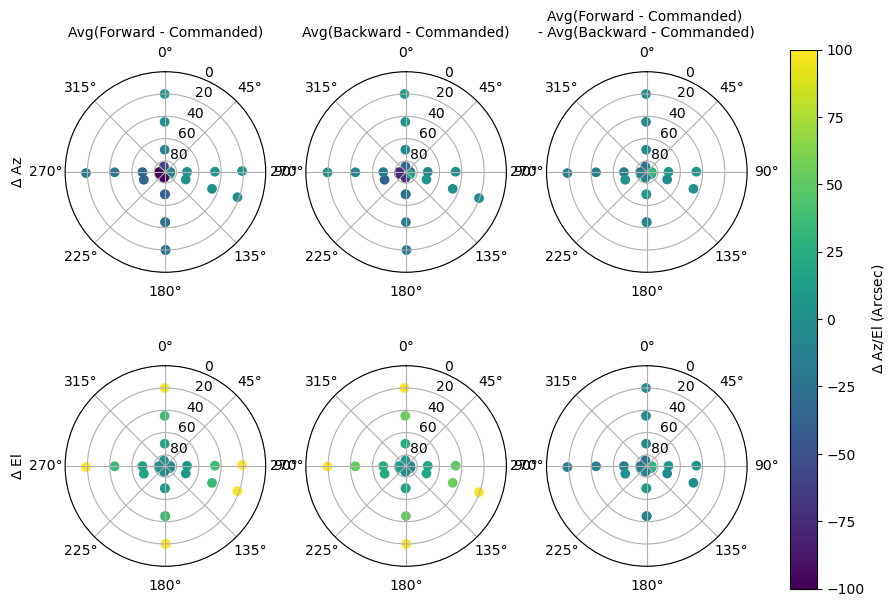

In [290]:
fig, ax = plt.subplots(2, 3, figsize=(11, 7), subplot_kw={'projection': 'polar'})
#ax = plt.sub
pts1 = ax[0, 0].scatter((dict_21['forward_azs'] * u.degree).to(u.radian), dict_21['forward_els'], c = dict_21['forward_dazs'],
                       vmin=-100, vmax=100)
ax[0, 1].scatter((dict_21['backward_azs'] * u.degree).to(u.radian), dict_21['backward_els'], c = dict_21['backward_dazs'],
                vmin=-100, vmax=100)
ax[0, 2].scatter((dict_21['diff_azs'] * u.degree).to(u.radian), dict_21['diff_els'], c = dict_21['diff_dazs'],
                 vmin=-100, vmax=100)
pts2 = ax[1, 0].scatter((dict_21['forward_azs'] * u.degree).to(u.radian), dict_21['forward_els'], c = dict_21['forward_dels'],
                        vmin=-100, vmax=100)
ax[1, 1].scatter((dict_21['backward_azs'] * u.degree).to(u.radian), dict_21['backward_els'], c = dict_21['backward_dels'],
                 vmin=-100, vmax=100)
ax[1, 2].scatter((dict_21['diff_azs'] * u.degree).to(u.radian), dict_21['diff_els'], c = dict_21['diff_dazs'],
                 vmin=-100, vmax=100)
#cbAx1 = fig.add_axes([0.92, 0.51, 0.03, 0.4])
#cbAx2 = fig.add_axes([0.92, 0.11, 0.03, 0.4])
fig.colorbar(pts1, label='$\Delta$ Az/El (Arcsec)', ax=ax)
#cb1 = fig.colorbar(pts1, label='$\Delta$ Az (degrees)', cax=cbAx1)
#cb2 = fig.colorbar(pts2, label='$\Delta$ Az (degrees)', cax=cbAx2)
ax[0, 0].set_ylabel('$\Delta$ Az')
ax[0, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[1, 0].set_ylabel('$\Delta$ El')
ax[1, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[0, 0].set_title('Avg(Forward - Commanded)', fontsize=10)
ax[0, 1].set_title('Avg(Backward - Commanded)', fontsize=10)
ax[0, 2].set_title('Avg(Forward - Commanded) \n- Avg(Backward - Commanded)', fontsize=10)
ax[0, 0].set_theta_zero_location("N")
ax[0, 0].set_theta_direction(-1)
ax[0, 0].set_rlim(90, 0)
ax[1, 0].set_theta_zero_location("N")
ax[1, 0].set_theta_direction(-1)
ax[1, 0].set_rlim(90, 0)
ax[0, 1].set_theta_zero_location("N")
ax[0, 1].set_theta_direction(-1)
ax[0, 1].set_rlim(90, 0)
ax[1, 1].set_theta_zero_location("N")
ax[1, 1].set_theta_direction(-1)
ax[1, 1].set_rlim(90, 0)
ax[0, 2].set_theta_zero_location("N")
ax[0, 2].set_theta_direction(-1)
ax[0, 2].set_rlim(90, 0)
ax[1, 2].set_theta_zero_location("N")
ax[1, 2].set_theta_direction(-1)
ax[1, 2].set_rlim(90, 0)
plt.savefig('ForwardReverse_03_21.png')

## Now look at the std deviation of all the measurements from both days 

In [282]:
all_fw_azs, all_fw_els, all_fw_daz_stds, all_fw_del_stds = [], [], [], []
for i, (az, el) in enumerate(zip(dict_21['forward_azs'], dict_21['forward_els'])):
    dist = (dict_22['forward_azs'] - az)**2 + (dict_22['forward_els'] - el)**2
    match_id = dist.argmin()
    tot_std_daz = np.nanstd(dict_21['forward_all_dazs'][i].to_list() + dict_22['forward_all_dazs'][match_id].to_list())
    tot_std_del = np.nanstd(dict_21['forward_all_dels'][i].to_list() + dict_22['forward_all_dels'][match_id].to_list())
    #print(az, el, dict_22['forward_azs'][match_id], dict_22['forward_els'][match_id])
    all_fw_azs.append(az)
    all_fw_els.append(el)
    all_fw_daz_stds.append(tot_std_daz)
    all_fw_del_stds.append(tot_std_del)
    
all_bw_azs, all_bw_els, all_bw_daz_stds, all_bw_del_stds = [], [], [], []
for i, (az, el) in enumerate(zip(dict_21['backward_azs'], dict_21['backward_els'])):
    dist = (dict_22['backward_azs'] - az)**2 + (dict_22['backward_els'] - el)**2
    match_id = dist.argmin()
    tot_std_daz = np.nanstd(dict_21['backward_all_dazs'][i].to_list() + dict_22['backward_all_dazs'][match_id].to_list())
    tot_std_del = np.nanstd(dict_21['backward_all_dels'][i].to_list() + dict_22['backward_all_dels'][match_id].to_list())
    #print(az, el, dict_22['backward_azs'][match_id], dict_22['backward_els'][match_id])
    all_bw_azs.append(az)
    all_bw_els.append(el)
    all_bw_daz_stds.append(tot_std_daz)
    all_bw_del_stds.append(tot_std_del)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-5.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


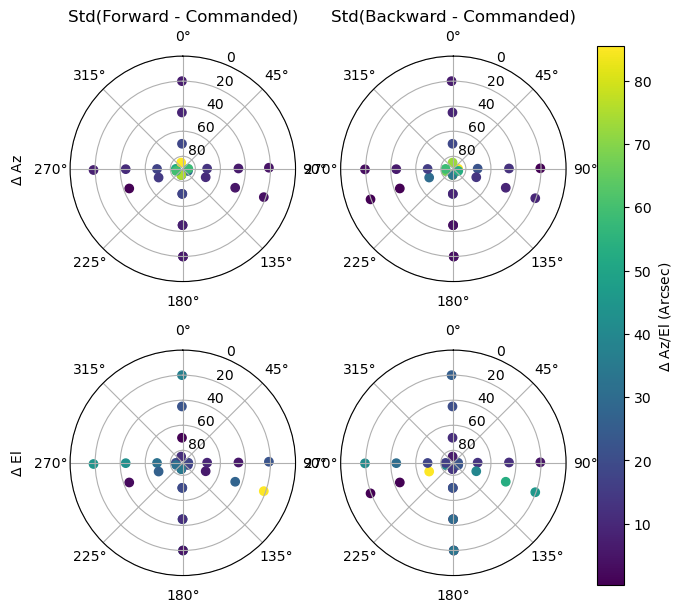

In [292]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7), subplot_kw={'projection': 'polar'})
pts1 = ax[0, 0].scatter((all_fw_azs * u.degree).to(u.radian), all_fw_els, c = all_fw_daz_stds,
                       )#vmin=-100, vmax=100)
ax[0, 1].scatter((all_bw_azs * u.degree).to(u.radian), all_bw_els, c = all_bw_daz_stds,
                )#vmin=-100, vmax=100)

pts2 = ax[1, 0].scatter((all_fw_azs * u.degree).to(u.radian), all_fw_els, c = all_fw_del_stds,
                       )#vmin=-100, vmax=100)
ax[1, 1].scatter((all_bw_azs * u.degree).to(u.radian), all_bw_els, c = all_bw_del_stds,
                 )#vmin=-100, vmax=100)

fig.colorbar(pts1, label='$\Delta$ Az/El (Arcsec)', ax=ax)
ax[0, 0].set_ylabel('$\Delta$ Az')
ax[0, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[1, 0].set_ylabel('$\Delta$ El')
ax[1, 0].yaxis.set_label_coords(-0.2, 0.5)
ax[0, 0].set_title('Std(Forward - Commanded)')
ax[0, 1].set_title('Std(Backward - Commanded)')
ax[0, 0].set_theta_zero_location("N")
ax[0, 0].set_theta_direction(-1)
ax[0, 0].set_rlim(90, 0)
ax[1, 0].set_theta_zero_location("N")
ax[1, 0].set_theta_direction(-1)
ax[1, 0].set_rlim(90, 0)
ax[0, 1].set_theta_zero_location("N")
ax[0, 1].set_theta_direction(-1)
ax[0, 1].set_rlim(90, 0)
ax[1, 1].set_theta_zero_location("N")
ax[1, 1].set_theta_direction(-1)
ax[1, 1].set_rlim(90, 0)
plt.savefig('ForwardReverse_std.png')